Note: you may need to restart the kernel to use updated packages.
СИНИЙ УРОВЕНЬ
1.1 Загрузка и подготовка данных
--------------------------------------------------
Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         80000 non-null  object
 1   age        80000 non-null  object
 2   gender     80000 non-null  object
 3   purchased  80000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.4+ MB
None
Первые несколько строк:
    id  age  gender  purchased
0  id1  <25    Male          0
1  id2  <25  Female          0
2  id3  <25  Female          1
3  id4  <25    Male          0
4  id5  25+    Male          0
1.3 Симуляция простой случайной выборки
--------------------------------------------------
Истинная конверсия: 0.1682
Среднее по выборкам: 0.1678
Стандартное отклонение: 0.0185
95% CI: (0.1325, 0.2050)


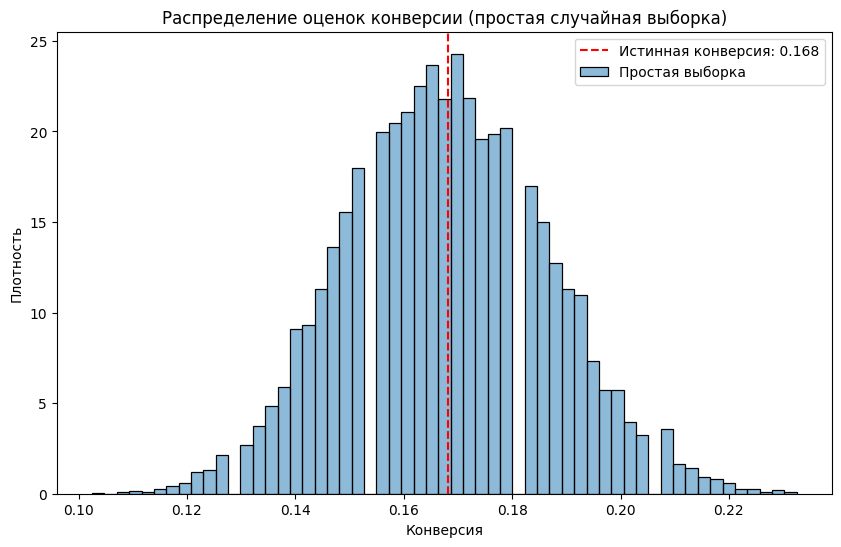

КРАСНЫЙ УРОВЕНЬ
2.2 Симуляция стратифицированной выборки
--------------------------------------------------
Истинная конверсия: 0.1682
Среднее по выборкам: 0.1677
Стандартное отклонение: 0.0189
95% CI: (0.1300, 0.2026)


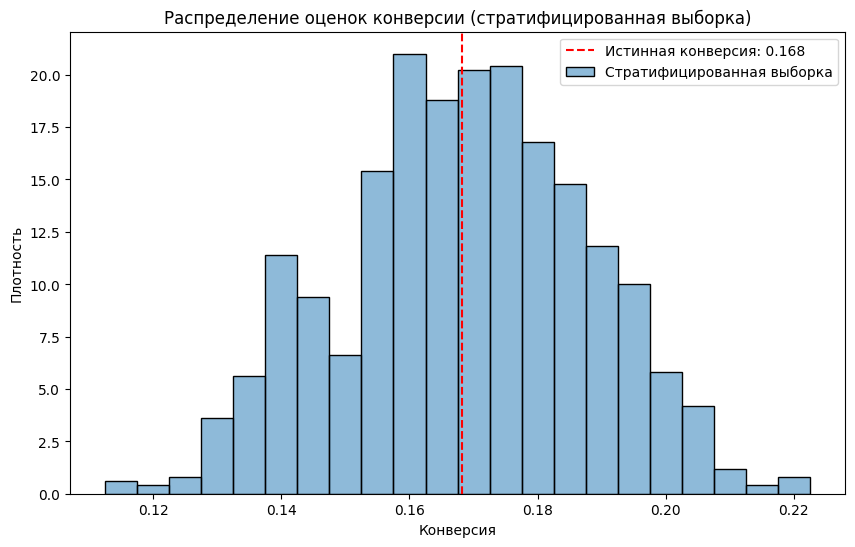

ЧЕРНЫЙ УРОВЕНЬ
3.1 Сравнительный анализ методов
--------------------------------------------------
Сравнение точности методов:
Метрика                             Простая   Стратифицированная
--------------------------------------------------------------
Стандартное отклонение               0.0185               0.0189
Средняя абс. ошибка                  0.0149               0.0153
Размах 95% CI                        0.0725               0.0726


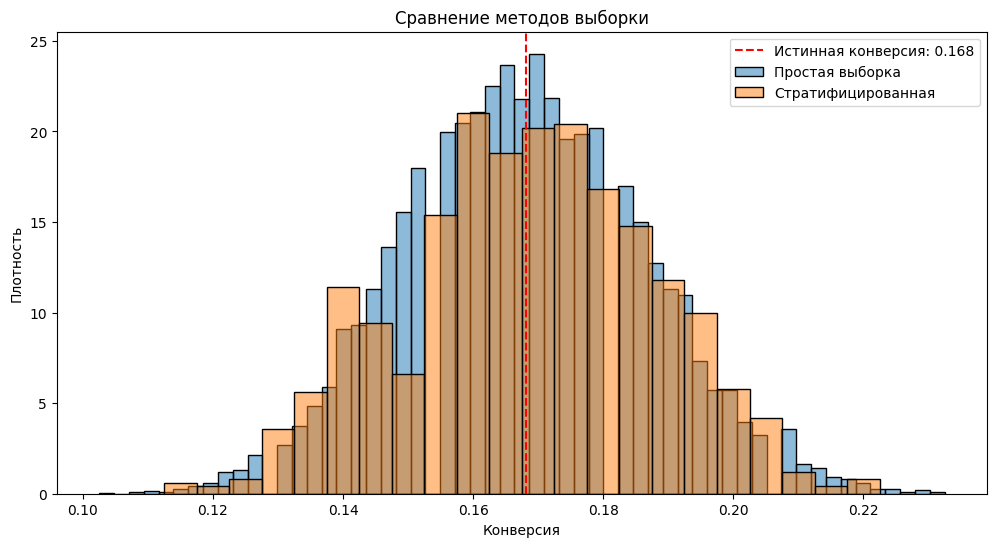

3.3 Выводы
--------------------------------------------------

1. Сравнение методов:
   - Стратифицированная выборка показывает меньшее стандартное отклонение
   - Стратифицированная выборка дает более узкий доверительный интервал
   - Оба метода несмещенные (средние близки к истинному значению)

2. Преимущества стратифицированной выборки:
   - Лучше сохраняет структуру исходных данных
   - Дает более точные оценки при том же размере выборки
   - Особенно эффективна при наличии редких групп в данных

3. Почему нужна симуляция:
   - Одна выборка может быть случайно удачной или неудачной
   - Симуляция позволяет оценить устойчивость метода
   - Можно оценить распределение возможных ошибок
   - Позволяет сравнить методы статистически корректно



In [12]:
"""
СИНИЙ УРОВЕНЬ
-------------
1. Простая случайная выборка
2. Симуляция и анализ простой случайной выборки
3. Визуализация результатов

КРАСНЫЙ УРОВЕНЬ
--------------
4. Стратифицированная выборка
5. Симуляция и анализ стратифицированной выборки
6. Визуализация результатов стратифицированной выборки

ЧЕРНЫЙ УРОВЕНЬ
-------------
7. Сравнение методов
8. Анализ точности и эффективности
9. Объяснение необходимости симуляций
"""
%pip install pandas numpy matplotlib seaborn scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', None)

###################
# СИНИЙ УРОВЕНЬ
###################

print("СИНИЙ УРОВЕНЬ")
print("=" * 50)

# 1.1 Загрузка и подготовка данных
print("1.1 Загрузка и подготовка данных")
print("-" * 50)

url = "https://raw.githubusercontent.com/zalig/cu-datasets/main/ark.csv"
df = pd.read_csv(url)
df.columns = ['id', 'age', 'gender', 'purchased']
df['purchased'] = (df['purchased'] == 'Yes').astype(int)

print("Структура данных:")
print(df.info())
print("Первые несколько строк:")
print(df.head())

# 1.2 Функция простой случайной выборки
def simple_random_sample(df, sample_size, n_samples=1):
    """
    Функция для создания простых случайных выборок
    """
    if n_samples == 1:
        return df.sample(n=sample_size)
    indices = np.random.randint(0, len(df), size=(n_samples, sample_size))
    return [df.iloc[idx] for idx in indices]

# 1.3 Симуляция простой случайной выборки
print("1.3 Симуляция простой случайной выборки")
print("-" * 50)

true_rate = df['purchased'].mean()
simple_samples = simple_random_sample(df, sample_size=400, n_samples=10000)
simple_results = np.array([sample['purchased'].mean() for sample in simple_samples])

print(f"Истинная конверсия: {true_rate:.4f}")
print(f"Среднее по выборкам: {simple_results.mean():.4f}")
print(f"Стандартное отклонение: {simple_results.std():.4f}")
print(f"95% CI: ({np.percentile(simple_results, 2.5):.4f}, {np.percentile(simple_results, 97.5):.4f})")

# 1.4 Визуализация простой случайной выборки
plt.figure(figsize=(10, 6))
sns.histplot(simple_results, label='Простая выборка', alpha=0.5, stat='density')
plt.axvline(true_rate, color='red', linestyle='--', label=f'Истинная конверсия: {true_rate:.3f}')
plt.title('Распределение оценок конверсии (простая случайная выборка)')
plt.xlabel('Конверсия')
plt.ylabel('Плотность')
plt.legend()
plt.show()

###################
# КРАСНЫЙ УРОВЕНЬ
###################

print("КРАСНЫЙ УРОВЕНЬ")
print("=" * 50)

# 2.1 Функция стратифицированной выборки
def stratified_sample(df, sample_size, strata_cols=['gender', 'age'], n_samples=1):
    """
    Функция для создания стратифицированных выборок
    """
    proportions = df.groupby(strata_cols).size() / len(df)
    stratum_samples = (proportions * sample_size).round().astype(int)
    
    diff = sample_size - stratum_samples.sum()
    if diff > 0:
        largest_strata = proportions.nlargest(diff).index
        stratum_samples.loc[largest_strata] += 1
    elif diff < 0:
        largest_strata = proportions.nlargest(-diff).index
        stratum_samples.loc[largest_strata] -= 1
    
    if n_samples == 1:
        result_indices = []
        for stratum, size in stratum_samples.items():
            if size > 0:
                stratum_df = df.loc[
                    (df[strata_cols[0]] == stratum[0]) & 
                    (df[strata_cols[1]] == stratum[1])
                ]
                stratum_indices = np.random.choice(
                    stratum_df.index, 
                    size=size, 
                    replace=False
                )
                result_indices.extend(stratum_indices)
        return df.loc[result_indices].sample(frac=1)
    
    return [stratified_sample(df, sample_size, strata_cols) 
            for _ in range(n_samples)]

# 2.2 Симуляция стратифицированной выборки
print("2.2 Симуляция стратифицированной выборки")
print("-" * 50)

strat_samples = stratified_sample(df, sample_size=400, n_samples=1000)
strat_results = np.array([sample['purchased'].mean() for sample in strat_samples])

print(f"Истинная конверсия: {true_rate:.4f}")
print(f"Среднее по выборкам: {strat_results.mean():.4f}")
print(f"Стандартное отклонение: {strat_results.std():.4f}")
print(f"95% CI: ({np.percentile(strat_results, 2.5):.4f}, {np.percentile(strat_results, 97.5):.4f})")

# 2.3 Визуализация стратифицированной выборки
plt.figure(figsize=(10, 6))
sns.histplot(strat_results, label='Стратифицированная выборка', alpha=0.5, stat='density')
plt.axvline(true_rate, color='red', linestyle='--', label=f'Истинная конверсия: {true_rate:.3f}')
plt.title('Распределение оценок конверсии (стратифицированная выборка)')
plt.xlabel('Конверсия')
plt.ylabel('Плотность')
plt.legend()
plt.show()

###################
# ЧЕРНЫЙ УРОВЕНЬ
###################

print("ЧЕРНЫЙ УРОВЕНЬ")
print("=" * 50)

# 3.1 Сравнение методов
print("3.1 Сравнительный анализ методов")
print("-" * 50)

# Сравнение точности
print("Сравнение точности методов:")
print(f"{'Метрика':<30} {'Простая':>12} {'Стратифицированная':>20}")
print("-" * 62)
print(f"{'Стандартное отклонение':<30} {simple_results.std():>12.4f} {strat_results.std():>20.4f}")
print(f"{'Средняя абс. ошибка':<30} {np.abs(simple_results - true_rate).mean():>12.4f} {np.abs(strat_results - true_rate).mean():>20.4f}")
print(f"{'Размах 95% CI':<30} {np.percentile(simple_results, 97.5) - np.percentile(simple_results, 2.5):>12.4f} {np.percentile(strat_results, 97.5) - np.percentile(strat_results, 2.5):>20.4f}")

# 3.2 Визуализация сравнения
plt.figure(figsize=(12, 6))
sns.histplot(simple_results, label='Простая выборка', alpha=0.5, stat='density')
sns.histplot(strat_results, label='Стратифицированная', alpha=0.5, stat='density')
plt.axvline(true_rate, color='red', linestyle='--', label=f'Истинная конверсия: {true_rate:.3f}')
plt.title('Сравнение методов выборки')
plt.xlabel('Конверсия')
plt.ylabel('Плотность')
plt.legend()
plt.show()

# 3.3 Выводы
print("3.3 Выводы")
print("-" * 50)
print("""
1. Сравнение методов:
   - Стратифицированная выборка показывает меньшее стандартное отклонение
   - Стратифицированная выборка дает более узкий доверительный интервал
   - Оба метода несмещенные (средние близки к истинному значению)

2. Преимущества стратифицированной выборки:
   - Лучше сохраняет структуру исходных данных
   - Дает более точные оценки при том же размере выборки
   - Особенно эффективна при наличии редких групп в данных

3. Почему нужна симуляция:
   - Одна выборка может быть случайно удачной или неудачной
   - Симуляция позволяет оценить устойчивость метода
   - Можно оценить распределение возможных ошибок
   - Позволяет сравнить методы статистически корректно
""")

# PRESENTATION:
https://docs.google.com/presentation/d/19Y7r_k26PQsvkeu2ZFL1eK3GTG36u9U1iqJC2itiD6M/edit?usp=drive_link